# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.4410827321466146 -2.602135961214298
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [41]:
# Data of the model
def model_input(state_size, lstm_size, batch_size=1):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    # GRU: Gated Recurrent Units
    gru = tf.nn.rnn_cell.GRUCell(lstm_size) # hidden size
    cell = tf.nn.rnn_cell.MultiRNNCell([gru], state_is_tuple=False)
    g_initial_state = cell.zero_state(batch_size, tf.float32) # feedback or lateral/recurrent connection from output
    d_initial_state = cell.zero_state(batch_size, tf.float32) # feedback or lateral/recurrent connection from output
    return states, actions, targetQs, rewards, cell, g_initial_state, d_initial_state

In [42]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [43]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [44]:
# MLP & Conv
# # Generator/Controller: Generating/prediting the actions
# def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
#     with tf.variable_scope('generator', reuse=reuse):
#         # First fully connected layer
#         h1 = tf.layers.dense(inputs=states, units=hidden_size)
#         bn1 = tf.layers.batch_normalization(h1, training=training)        
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
#         bn2 = tf.layers.batch_normalization(h2, training=training)        
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         logits = tf.layers.dense(inputs=nl2, units=action_size)        
#         #predictions = tf.nn.softmax(logits)

#         # return actions logits
#         return logits

In [45]:
# RNN generator or sequence generator
def generator(states, initial_state, cell, lstm_size, num_classes, reuse=False): 
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        inputs = tf.layers.dense(inputs=states, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        # dynamic means adapt to the batch_size
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=num_classes)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [46]:
# MLP & Conv
# # Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
# def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
#     with tf.variable_scope('discriminator', reuse=reuse):
#         # Fusion/merge states and actions/ SA/ SM
#         x_fused = tf.concat(axis=1, values=[states, actions])
        
#         # First fully connected layer
#         h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
#         bn1 = tf.layers.batch_normalization(h1, training=training)        
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
#         bn2 = tf.layers.batch_normalization(h2, training=training)        
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         logits = tf.layers.dense(inputs=nl2, units=1)        
#         #predictions = tf.nn.softmax(logits)

#         # return rewards logits
#         return logits

In [47]:
# RNN generator or sequence generator
def discriminator(states, actions, initial_state, cell, lstm_size, reuse=False): 
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        inputs = tf.layers.dense(inputs=x_fused, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=1)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [55]:
def model_loss(action_size, hidden_size, states, actions, 
               targetQs, rewards,
               cell, g_initial_state, d_initial_state):
    # G/Actor
    #actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_logits, g_final_state = generator(states=states, num_classes=action_size, 
                                              cell=cell, initial_state=g_initial_state, lstm_size=hidden_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions * targetQs)
    
    # D/Critic
    #Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    Qs_logits, d_final_state = discriminator(states=states, actions=actions_logits, 
                                             cell=cell, initial_state=d_initial_state, lstm_size=hidden_size)
    #d_lossQ = tf.reduce_mean(tf.square(tf.reshape(Qs_logits, [-1]) - targetQs))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=tf.nn.sigmoid(targetQs)))
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    d_loss = d_lossQ + d_lossR

    return actions_logits, Qs_logits, g_final_state, d_final_state, g_loss, d_loss, d_lossQ, d_lossR

In [56]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize RNN
    # g_grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(g_loss, g_vars), clip_norm=5) # usually around 1-5
    # d_grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(d_loss, d_vars), clip_norm=5) # usually around 1-5
    g_grads=tf.gradients(g_loss, g_vars)
    d_grads=tf.gradients(d_loss, d_vars)
    g_opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(g_grads, g_vars))
    d_opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(d_grads, d_vars))
    
    # # Optimize MLP & CNN
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    #     g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
    #     d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [57]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rewards, cell, self.g_initial_state, self.d_initial_state = model_input(
            state_size=state_size, lstm_size=hidden_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_final_state, self.d_final_state, self.g_loss, self.d_loss, self.d_lossQ, self.d_lossR = model_loss(
            action_size=action_size, hidden_size=hidden_size,
            states=self.states, actions=self.actions, cell=cell, 
            targetQs=self.targetQs, rewards=self.rewards,
            g_initial_state=self.g_initial_state, d_initial_state=self.d_initial_state)
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

In [58]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        self.states = deque(maxlen=max_size)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [59]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [60]:
# Training parameters
# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 64                # number of samples in the memory/ experience as mini-batch size
learning_rate = 0.001          # learning rate for adam

In [64]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)
(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 1)


In [65]:
state = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

In [66]:
memory.buffer[0]

[array([ 0.01186393, -0.03154306,  0.02263703,  0.02156626]),
 1,
 array([ 0.01123307,  0.16324706,  0.02306835, -0.26388935]),
 1.0,
 0.0]

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
from collections import deque
episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossQ_list, d_lossR_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        state = env.reset() # env first state
        g_initial_state = sess.run(model.g_initial_state)
        d_initial_state = sess.run(model.d_initial_state)

        # Training steps/batches
        while True:
            # Testing/inference
            action_logits, g_final_state, d_final_state = sess.run(
                fetches=[model.actions_logits, model.g_final_state, model.d_final_state], 
                feed_dict={model.states: np.reshape(state, [1, -1]),
                           model.g_initial_state: g_initial_state,
                           model.d_initial_state: d_initial_state})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.states.append([g_initial_state, g_final_state,
                                  d_initial_state, d_final_state])
            total_reward += reward
            g_initial_state = g_final_state
            d_initial_state = d_final_state
            state = next_state
            
            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rnn_states = memory.states
            g_initial_states = np.array([each[0] for each in rnn_states])
            g_final_states = np.array([each[1] for each in rnn_states])
            d_initial_states = np.array([each[2] for each in rnn_states])
            d_final_states = np.array([each[3] for each in rnn_states])
            nextQs_logits = sess.run(fetches = model.Qs_logits,
                                     feed_dict = {model.states: next_states, 
                                                  model.g_initial_state: g_final_states[0].reshape([1, -1]),
                                                  model.d_initial_state: d_final_states[0].reshape([1, -1])})
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # exploit
            targetQs = rewards + (0.99 * nextQs)
            g_loss, d_loss, d_lossQ, d_lossR, _, _ = sess.run(
                fetches=[model.g_loss, model.d_loss, 
                         model.d_lossQ, model.d_lossR,
                         model.g_opt, model.d_opt], 
                feed_dict = {model.states: states, model.actions: actions,
                             model.targetQs: targetQs, model.rewards: rewards,
                             model.g_initial_state: g_initial_states[0].reshape([1, -1]),
                             model.d_initial_state: d_initial_states[0].reshape([1, -1])})
            if done is True:
                break

        # Episode total reward and success rate/prob
        episode_reward.append(total_reward) # stopping criteria
        rate = total_reward/ 500 # success is 500 points: 0-1
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossQ:{:.4f}'.format(d_lossQ),
              'dlossR:{:.4f}'.format(d_lossR))
        # Ploting out
        rewards_list.append([ep, np.mean(episode_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossQ_list.append([ep, d_lossQ])
        d_lossR_list.append([ep, d_lossR])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-seq3.ckpt')

Episode:0 meanR:22.0000 rate:0.0440 gloss:0.8156 dloss:1.1801 dlossQ:0.6214 dlossR:0.5586
Episode:1 meanR:33.5000 rate:0.0900 gloss:0.9426 dloss:0.5348 dlossQ:0.3262 dlossR:0.2087
Episode:2 meanR:32.6667 rate:0.0620 gloss:0.5829 dloss:0.2031 dlossQ:0.1429 dlossR:0.0603
Episode:3 meanR:37.7500 rate:0.1060 gloss:0.0346 dloss:0.0735 dlossQ:0.0651 dlossR:0.0084
Episode:4 meanR:39.2000 rate:0.0900 gloss:0.0007 dloss:0.0625 dlossQ:0.0590 dlossR:0.0034
Episode:5 meanR:39.5000 rate:0.0820 gloss:0.0005 dloss:0.0617 dlossQ:0.0585 dlossR:0.0033
Episode:6 meanR:37.1429 rate:0.0460 gloss:0.0191 dloss:0.1174 dlossQ:0.0891 dlossR:0.0283
Episode:7 meanR:38.0000 rate:0.0880 gloss:0.0011 dloss:0.0748 dlossQ:0.0657 dlossR:0.0090
Episode:8 meanR:37.8889 rate:0.0740 gloss:0.0001 dloss:0.0623 dlossQ:0.0587 dlossR:0.0036
Episode:9 meanR:37.6000 rate:0.0700 gloss:0.0002 dloss:0.0629 dlossQ:0.0592 dlossR:0.0036
Episode:10 meanR:39.4545 rate:0.1160 gloss:0.4291 dloss:0.0728 dlossQ:0.0640 dlossR:0.0088
Episode:1

Episode:91 meanR:37.9022 rate:0.0460 gloss:0.0000 dloss:0.0724 dlossQ:0.0623 dlossR:0.0101
Episode:92 meanR:37.7849 rate:0.0540 gloss:0.0000 dloss:0.0795 dlossQ:0.0672 dlossR:0.0123
Episode:93 meanR:38.0532 rate:0.1260 gloss:0.0005 dloss:0.0389 dlossQ:0.0299 dlossR:0.0090
Episode:94 meanR:38.2105 rate:0.1060 gloss:0.0005 dloss:0.0626 dlossQ:0.0555 dlossR:0.0072
Episode:95 meanR:38.1146 rate:0.0580 gloss:0.0002 dloss:0.0445 dlossQ:0.0413 dlossR:0.0032
Episode:96 meanR:38.2165 rate:0.0960 gloss:0.0000 dloss:0.0503 dlossQ:0.0390 dlossR:0.0112
Episode:97 meanR:38.2653 rate:0.0860 gloss:0.0000 dloss:0.0625 dlossQ:0.0498 dlossR:0.0127
Episode:98 meanR:38.2222 rate:0.0680 gloss:0.0000 dloss:0.0470 dlossQ:0.0436 dlossR:0.0034
Episode:99 meanR:38.4700 rate:0.1260 gloss:0.0009 dloss:0.0464 dlossQ:0.0414 dlossR:0.0050
Episode:100 meanR:38.4800 rate:0.0460 gloss:0.0005 dloss:0.0697 dlossQ:0.0522 dlossR:0.0174
Episode:101 meanR:38.2700 rate:0.0480 gloss:0.0002 dloss:0.0850 dlossQ:0.0742 dlossR:0.01

Episode:181 meanR:39.6000 rate:0.0780 gloss:0.0001 dloss:0.0642 dlossQ:0.0533 dlossR:0.0109
Episode:182 meanR:39.6600 rate:0.0560 gloss:0.0000 dloss:0.0456 dlossQ:0.0395 dlossR:0.0062
Episode:183 meanR:39.6400 rate:0.0580 gloss:0.0000 dloss:0.1088 dlossQ:0.0928 dlossR:0.0160
Episode:184 meanR:39.1100 rate:0.0440 gloss:0.0000 dloss:0.0698 dlossQ:0.0612 dlossR:0.0086
Episode:185 meanR:39.0500 rate:0.0600 gloss:0.0000 dloss:0.0935 dlossQ:0.0785 dlossR:0.0150
Episode:186 meanR:38.7200 rate:0.0960 gloss:0.0000 dloss:0.0577 dlossQ:0.0491 dlossR:0.0086
Episode:187 meanR:38.6900 rate:0.0560 gloss:0.0000 dloss:0.0478 dlossQ:0.0405 dlossR:0.0073
Episode:188 meanR:38.4900 rate:0.0460 gloss:0.0000 dloss:0.0786 dlossQ:0.0684 dlossR:0.0102
Episode:189 meanR:38.4200 rate:0.0660 gloss:0.0000 dloss:0.0733 dlossQ:0.0609 dlossR:0.0124
Episode:190 meanR:38.5400 rate:0.0680 gloss:0.0000 dloss:0.0367 dlossQ:0.0319 dlossR:0.0049
Episode:191 meanR:38.6700 rate:0.0720 gloss:0.0000 dloss:0.0723 dlossQ:0.0571 dl

Episode:271 meanR:39.3500 rate:0.0620 gloss:0.0000 dloss:0.0772 dlossQ:0.0654 dlossR:0.0118
Episode:272 meanR:39.4500 rate:0.0660 gloss:0.0003 dloss:0.0420 dlossQ:0.0362 dlossR:0.0059
Episode:273 meanR:39.5700 rate:0.0760 gloss:0.0000 dloss:0.0381 dlossQ:0.0331 dlossR:0.0049
Episode:274 meanR:39.3500 rate:0.0480 gloss:0.0000 dloss:0.0896 dlossQ:0.0779 dlossR:0.0118
Episode:275 meanR:39.4200 rate:0.1020 gloss:0.0000 dloss:0.0588 dlossQ:0.0475 dlossR:0.0113
Episode:276 meanR:39.2300 rate:0.0420 gloss:0.0000 dloss:0.0384 dlossQ:0.0339 dlossR:0.0045
Episode:277 meanR:39.2300 rate:0.0440 gloss:0.0000 dloss:0.0542 dlossQ:0.0473 dlossR:0.0069
Episode:278 meanR:39.3800 rate:0.0900 gloss:0.0000 dloss:0.0686 dlossQ:0.0551 dlossR:0.0134
Episode:279 meanR:39.3300 rate:0.0840 gloss:0.0000 dloss:0.0371 dlossQ:0.0314 dlossR:0.0057
Episode:280 meanR:39.1200 rate:0.0680 gloss:0.0000 dloss:0.0368 dlossQ:0.0322 dlossR:0.0047
Episode:281 meanR:39.0000 rate:0.0540 gloss:0.0000 dloss:0.0779 dlossQ:0.0641 dl

Episode:361 meanR:36.7500 rate:0.0460 gloss:0.0000 dloss:0.1273 dlossQ:0.0988 dlossR:0.0285
Episode:362 meanR:36.7700 rate:0.0620 gloss:0.0000 dloss:0.1654 dlossQ:0.1183 dlossR:0.0470
Episode:363 meanR:36.8000 rate:0.0580 gloss:0.0000 dloss:0.0675 dlossQ:0.0589 dlossR:0.0086
Episode:364 meanR:36.7300 rate:0.0500 gloss:0.0000 dloss:0.0588 dlossQ:0.0514 dlossR:0.0074
Episode:365 meanR:36.3400 rate:0.0540 gloss:0.0000 dloss:0.0583 dlossQ:0.0480 dlossR:0.0103
Episode:366 meanR:36.3700 rate:0.0480 gloss:0.0000 dloss:0.0606 dlossQ:0.0499 dlossR:0.0107
Episode:367 meanR:36.3400 rate:0.1040 gloss:0.0061 dloss:0.0887 dlossQ:0.0606 dlossR:0.0281
Episode:368 meanR:36.2000 rate:0.0860 gloss:0.0003 dloss:0.0515 dlossQ:0.0424 dlossR:0.0091
Episode:369 meanR:35.8700 rate:0.0440 gloss:0.0000 dloss:0.0363 dlossQ:0.0331 dlossR:0.0032
Episode:370 meanR:35.9500 rate:0.1260 gloss:0.0002 dloss:0.0746 dlossQ:0.0634 dlossR:0.0112
Episode:371 meanR:36.1600 rate:0.1040 gloss:0.0017 dloss:0.0463 dlossQ:0.0416 dl

Episode:451 meanR:35.9600 rate:0.0600 gloss:-0.0000 dloss:0.1041 dlossQ:0.0856 dlossR:0.0184
Episode:452 meanR:35.9800 rate:0.0520 gloss:0.0000 dloss:0.1038 dlossQ:0.0829 dlossR:0.0209
Episode:453 meanR:35.9100 rate:0.0620 gloss:0.0000 dloss:0.1068 dlossQ:0.0806 dlossR:0.0262
Episode:454 meanR:36.2600 rate:0.1200 gloss:0.0380 dloss:0.0790 dlossQ:0.0718 dlossR:0.0071
Episode:455 meanR:36.2200 rate:0.0840 gloss:0.0000 dloss:0.0410 dlossQ:0.0355 dlossR:0.0055
Episode:456 meanR:36.3200 rate:0.1240 gloss:0.0022 dloss:0.0374 dlossQ:0.0340 dlossR:0.0034
Episode:457 meanR:36.1400 rate:0.0560 gloss:0.0001 dloss:0.1226 dlossQ:0.1003 dlossR:0.0223
Episode:458 meanR:36.2800 rate:0.0920 gloss:0.0000 dloss:0.0410 dlossQ:0.0384 dlossR:0.0026
Episode:459 meanR:36.1600 rate:0.0760 gloss:0.0000 dloss:0.1060 dlossQ:0.0867 dlossR:0.0193
Episode:460 meanR:36.1300 rate:0.0460 gloss:0.0000 dloss:0.1713 dlossQ:0.1376 dlossR:0.0337
Episode:461 meanR:36.3100 rate:0.0820 gloss:0.0008 dloss:0.0647 dlossQ:0.0643 d

Episode:541 meanR:36.8600 rate:0.1000 gloss:0.0000 dloss:0.0392 dlossQ:0.0321 dlossR:0.0071
Episode:542 meanR:36.9200 rate:0.0540 gloss:0.0000 dloss:0.0351 dlossQ:0.0311 dlossR:0.0040
Episode:543 meanR:36.7900 rate:0.0460 gloss:0.0000 dloss:0.0669 dlossQ:0.0557 dlossR:0.0112
Episode:544 meanR:36.7400 rate:0.0560 gloss:0.0000 dloss:0.0738 dlossQ:0.0609 dlossR:0.0129
Episode:545 meanR:36.4400 rate:0.0520 gloss:0.0000 dloss:0.0687 dlossQ:0.0558 dlossR:0.0128
Episode:546 meanR:36.3500 rate:0.0640 gloss:0.0000 dloss:0.0564 dlossQ:0.0495 dlossR:0.0069
Episode:547 meanR:36.2600 rate:0.0760 gloss:0.0000 dloss:0.0344 dlossQ:0.0304 dlossR:0.0040
Episode:548 meanR:36.5200 rate:0.1040 gloss:0.0000 dloss:0.0441 dlossQ:0.0344 dlossR:0.0097
Episode:549 meanR:36.1200 rate:0.0500 gloss:0.0000 dloss:0.0356 dlossQ:0.0317 dlossR:0.0039
Episode:550 meanR:36.5000 rate:0.1200 gloss:0.0000 dloss:0.0358 dlossQ:0.0310 dlossR:0.0048
Episode:551 meanR:36.5400 rate:0.0680 gloss:0.0000 dloss:0.0377 dlossQ:0.0331 dl

Episode:631 meanR:35.6700 rate:0.0540 gloss:0.0000 dloss:0.0825 dlossQ:0.0681 dlossR:0.0145
Episode:632 meanR:35.8400 rate:0.0860 gloss:0.0000 dloss:0.0388 dlossQ:0.0346 dlossR:0.0042
Episode:633 meanR:35.7100 rate:0.0500 gloss:0.0000 dloss:0.0372 dlossQ:0.0324 dlossR:0.0049
Episode:634 meanR:35.3300 rate:0.0540 gloss:0.0000 dloss:0.0657 dlossQ:0.0552 dlossR:0.0104
Episode:635 meanR:35.3100 rate:0.0680 gloss:0.0000 dloss:0.0788 dlossQ:0.0667 dlossR:0.0121
Episode:636 meanR:35.2200 rate:0.0760 gloss:0.0000 dloss:0.0452 dlossQ:0.0351 dlossR:0.0101
Episode:637 meanR:35.6400 rate:0.1300 gloss:0.0000 dloss:0.0180 dlossQ:0.0168 dlossR:0.0012
Episode:638 meanR:35.8500 rate:0.0940 gloss:0.0000 dloss:0.0543 dlossQ:0.0494 dlossR:0.0050
Episode:639 meanR:35.8000 rate:0.0400 gloss:0.0000 dloss:0.0398 dlossQ:0.0363 dlossR:0.0035
Episode:640 meanR:35.7500 rate:0.0700 gloss:0.0000 dloss:0.0684 dlossQ:0.0546 dlossR:0.0137
Episode:641 meanR:35.5400 rate:0.0580 gloss:0.0002 dloss:0.0400 dlossQ:0.0350 dl

Episode:721 meanR:36.9900 rate:0.1300 gloss:0.0000 dloss:0.0202 dlossQ:0.0162 dlossR:0.0041
Episode:722 meanR:37.0300 rate:0.0600 gloss:0.0000 dloss:0.0541 dlossQ:0.0447 dlossR:0.0095
Episode:723 meanR:36.7100 rate:0.0460 gloss:0.0000 dloss:0.0745 dlossQ:0.0617 dlossR:0.0128
Episode:724 meanR:36.7800 rate:0.0940 gloss:-0.0000 dloss:0.0591 dlossQ:0.0465 dlossR:0.0127
Episode:725 meanR:37.4500 rate:0.1940 gloss:0.0000 dloss:0.0175 dlossQ:0.0170 dlossR:0.0005
Episode:726 meanR:37.4200 rate:0.0560 gloss:0.0000 dloss:0.0472 dlossQ:0.0370 dlossR:0.0102
Episode:727 meanR:37.5700 rate:0.1100 gloss:0.0000 dloss:0.0428 dlossQ:0.0362 dlossR:0.0066
Episode:728 meanR:37.5200 rate:0.0540 gloss:0.0000 dloss:0.0530 dlossQ:0.0439 dlossR:0.0091
Episode:729 meanR:37.8600 rate:0.1140 gloss:0.0000 dloss:0.0570 dlossQ:0.0466 dlossR:0.0105
Episode:730 meanR:37.8200 rate:0.0460 gloss:0.0000 dloss:0.0520 dlossQ:0.0421 dlossR:0.0099
Episode:731 meanR:38.2900 rate:0.1480 gloss:0.0000 dloss:0.0162 dlossQ:0.0149 d

Episode:811 meanR:37.7900 rate:0.0400 gloss:0.0000 dloss:0.0549 dlossQ:0.0484 dlossR:0.0065
Episode:812 meanR:37.7000 rate:0.0620 gloss:0.0000 dloss:0.0566 dlossQ:0.0480 dlossR:0.0087
Episode:813 meanR:37.9300 rate:0.0940 gloss:0.0000 dloss:0.0368 dlossQ:0.0314 dlossR:0.0054
Episode:814 meanR:38.3000 rate:0.1240 gloss:0.0000 dloss:0.0443 dlossQ:0.0374 dlossR:0.0069
Episode:815 meanR:38.2700 rate:0.0460 gloss:0.0000 dloss:0.0906 dlossQ:0.0616 dlossR:0.0290
Episode:816 meanR:38.3700 rate:0.0720 gloss:0.0000 dloss:0.1081 dlossQ:0.0812 dlossR:0.0269
Episode:817 meanR:38.9500 rate:0.1720 gloss:0.0000 dloss:0.0217 dlossQ:0.0207 dlossR:0.0010
Episode:818 meanR:39.0500 rate:0.0880 gloss:0.0000 dloss:0.0409 dlossQ:0.0368 dlossR:0.0041
Episode:819 meanR:39.1500 rate:0.0980 gloss:0.0000 dloss:0.0415 dlossQ:0.0347 dlossR:0.0068
Episode:820 meanR:39.1300 rate:0.0440 gloss:0.0000 dloss:0.0374 dlossQ:0.0332 dlossR:0.0042
Episode:821 meanR:38.7500 rate:0.0540 gloss:0.0000 dloss:0.0628 dlossQ:0.0509 dl

Episode:901 meanR:37.8300 rate:0.0600 gloss:0.0000 dloss:0.0422 dlossQ:0.0356 dlossR:0.0065
Episode:902 meanR:37.4900 rate:0.0520 gloss:0.0000 dloss:0.0610 dlossQ:0.0505 dlossR:0.0105
Episode:903 meanR:37.7000 rate:0.0860 gloss:0.0000 dloss:0.0378 dlossQ:0.0314 dlossR:0.0064
Episode:904 meanR:37.5400 rate:0.0600 gloss:0.0000 dloss:0.0412 dlossQ:0.0350 dlossR:0.0062
Episode:905 meanR:37.5300 rate:0.0440 gloss:0.0000 dloss:0.0587 dlossQ:0.0519 dlossR:0.0069
Episode:906 meanR:37.8000 rate:0.1160 gloss:0.0000 dloss:0.0397 dlossQ:0.0319 dlossR:0.0078
Episode:907 meanR:37.7600 rate:0.0480 gloss:0.0000 dloss:0.0343 dlossQ:0.0297 dlossR:0.0046
Episode:908 meanR:37.8900 rate:0.1160 gloss:0.0000 dloss:0.0368 dlossQ:0.0307 dlossR:0.0062
Episode:909 meanR:38.0300 rate:0.0720 gloss:0.0000 dloss:0.0341 dlossQ:0.0297 dlossR:0.0044
Episode:910 meanR:38.2400 rate:0.0980 gloss:0.0000 dloss:0.0348 dlossQ:0.0297 dlossR:0.0051
Episode:911 meanR:38.2900 rate:0.0500 gloss:0.0000 dloss:0.0353 dlossQ:0.0313 dl

Episode:991 meanR:35.2900 rate:0.1700 gloss:0.0000 dloss:0.0280 dlossQ:0.0199 dlossR:0.0081
Episode:992 meanR:35.2000 rate:0.0480 gloss:0.0000 dloss:0.0385 dlossQ:0.0322 dlossR:0.0063
Episode:993 meanR:35.5200 rate:0.1120 gloss:0.0000 dloss:0.0397 dlossQ:0.0319 dlossR:0.0078
Episode:994 meanR:36.0100 rate:0.1640 gloss:0.0000 dloss:0.0176 dlossQ:0.0150 dlossR:0.0026
Episode:995 meanR:36.3100 rate:0.1120 gloss:0.0000 dloss:0.0422 dlossQ:0.0380 dlossR:0.0043
Episode:996 meanR:36.1400 rate:0.0820 gloss:0.0000 dloss:0.0384 dlossQ:0.0321 dlossR:0.0063
Episode:997 meanR:36.0700 rate:0.0500 gloss:0.0000 dloss:0.0356 dlossQ:0.0315 dlossR:0.0041
Episode:998 meanR:35.9400 rate:0.0500 gloss:0.0000 dloss:0.0555 dlossQ:0.0470 dlossR:0.0084
Episode:999 meanR:36.1400 rate:0.0920 gloss:0.0000 dloss:0.0452 dlossQ:0.0392 dlossR:0.0061
Episode:1000 meanR:36.0000 rate:0.0620 gloss:0.0000 dloss:0.0351 dlossQ:0.0300 dlossR:0.0051
Episode:1001 meanR:36.0800 rate:0.0760 gloss:0.0000 dloss:0.0416 dlossQ:0.0344 

Episode:1080 meanR:39.0800 rate:0.1000 gloss:0.0000 dloss:0.0366 dlossQ:0.0305 dlossR:0.0061
Episode:1081 meanR:39.0600 rate:0.0560 gloss:0.0000 dloss:0.0356 dlossQ:0.0321 dlossR:0.0035
Episode:1082 meanR:38.7100 rate:0.0520 gloss:0.0000 dloss:0.0535 dlossQ:0.0456 dlossR:0.0078
Episode:1083 meanR:38.8800 rate:0.0760 gloss:0.0000 dloss:0.0350 dlossQ:0.0298 dlossR:0.0053
Episode:1084 meanR:38.8600 rate:0.0460 gloss:0.0000 dloss:0.0551 dlossQ:0.0456 dlossR:0.0095
Episode:1085 meanR:38.8700 rate:0.0520 gloss:0.0000 dloss:0.0547 dlossQ:0.0464 dlossR:0.0082
Episode:1086 meanR:38.6700 rate:0.0500 gloss:0.0000 dloss:0.0537 dlossQ:0.0460 dlossR:0.0077
Episode:1087 meanR:38.6700 rate:0.0540 gloss:0.0000 dloss:0.0548 dlossQ:0.0463 dlossR:0.0085
Episode:1088 meanR:38.8900 rate:0.0840 gloss:0.0000 dloss:0.0403 dlossQ:0.0327 dlossR:0.0075
Episode:1089 meanR:39.4500 rate:0.1720 gloss:0.0000 dloss:0.0194 dlossQ:0.0157 dlossR:0.0037
Episode:1090 meanR:39.3300 rate:0.0500 gloss:0.0000 dloss:0.0384 dloss

Episode:1169 meanR:37.2300 rate:0.0900 gloss:0.0000 dloss:0.0358 dlossQ:0.0302 dlossR:0.0056
Episode:1170 meanR:37.7100 rate:0.1420 gloss:0.0000 dloss:0.0173 dlossQ:0.0147 dlossR:0.0025
Episode:1171 meanR:38.1100 rate:0.1280 gloss:0.0000 dloss:0.0247 dlossQ:0.0185 dlossR:0.0062
Episode:1172 meanR:38.1700 rate:0.0620 gloss:0.0000 dloss:0.0362 dlossQ:0.0304 dlossR:0.0058
Episode:1173 meanR:38.6600 rate:0.1400 gloss:0.0000 dloss:0.0181 dlossQ:0.0151 dlossR:0.0030
Episode:1174 meanR:38.6800 rate:0.0520 gloss:0.0000 dloss:0.0344 dlossQ:0.0305 dlossR:0.0039
Episode:1175 meanR:38.8900 rate:0.0860 gloss:0.0000 dloss:0.0410 dlossQ:0.0326 dlossR:0.0084
Episode:1176 meanR:39.3200 rate:0.1640 gloss:0.0000 dloss:0.0179 dlossQ:0.0161 dlossR:0.0019
Episode:1177 meanR:39.1500 rate:0.1060 gloss:0.0000 dloss:0.0437 dlossQ:0.0347 dlossR:0.0090
Episode:1178 meanR:38.9000 rate:0.0760 gloss:0.0000 dloss:0.0369 dlossQ:0.0306 dlossR:0.0063
Episode:1179 meanR:38.9800 rate:0.1080 gloss:0.0000 dloss:0.0345 dloss

Episode:1258 meanR:36.8100 rate:0.0580 gloss:0.0000 dloss:0.0359 dlossQ:0.0311 dlossR:0.0048
Episode:1259 meanR:36.8800 rate:0.0600 gloss:0.0000 dloss:0.0563 dlossQ:0.0473 dlossR:0.0091
Episode:1260 meanR:36.8400 rate:0.0440 gloss:0.0000 dloss:0.0550 dlossQ:0.0472 dlossR:0.0078
Episode:1261 meanR:37.0100 rate:0.0880 gloss:0.0000 dloss:0.0348 dlossQ:0.0297 dlossR:0.0051
Episode:1262 meanR:37.1400 rate:0.0720 gloss:0.0000 dloss:0.0419 dlossQ:0.0336 dlossR:0.0083
Episode:1263 meanR:37.1100 rate:0.0500 gloss:0.0000 dloss:0.0538 dlossQ:0.0477 dlossR:0.0060
Episode:1264 meanR:37.4200 rate:0.1120 gloss:0.0000 dloss:0.0452 dlossQ:0.0364 dlossR:0.0088
Episode:1265 meanR:37.4100 rate:0.0540 gloss:0.0000 dloss:0.0448 dlossQ:0.0345 dlossR:0.0103
Episode:1266 meanR:37.4500 rate:0.0920 gloss:0.0000 dloss:0.0384 dlossQ:0.0338 dlossR:0.0046
Episode:1267 meanR:37.4700 rate:0.0640 gloss:0.0000 dloss:0.0352 dlossQ:0.0298 dlossR:0.0054
Episode:1268 meanR:37.3000 rate:0.0640 gloss:0.0000 dloss:0.0346 dloss

Episode:1347 meanR:34.0400 rate:0.0560 gloss:0.0000 dloss:0.0592 dlossQ:0.0491 dlossR:0.0101
Episode:1348 meanR:33.9700 rate:0.0720 gloss:0.0000 dloss:0.0398 dlossQ:0.0323 dlossR:0.0076
Episode:1349 meanR:34.1500 rate:0.0840 gloss:0.0000 dloss:0.0347 dlossQ:0.0297 dlossR:0.0050
Episode:1350 meanR:34.4200 rate:0.0980 gloss:0.0000 dloss:0.0344 dlossQ:0.0307 dlossR:0.0037
Episode:1351 meanR:34.2400 rate:0.0620 gloss:0.0000 dloss:0.0427 dlossQ:0.0353 dlossR:0.0073
Episode:1352 meanR:34.3200 rate:0.0620 gloss:0.0000 dloss:0.0654 dlossQ:0.0531 dlossR:0.0123
Episode:1353 meanR:34.3100 rate:0.0500 gloss:0.0000 dloss:0.0597 dlossQ:0.0524 dlossR:0.0072
Episode:1354 meanR:34.3200 rate:0.0540 gloss:0.0000 dloss:0.0628 dlossQ:0.0536 dlossR:0.0092
Episode:1355 meanR:34.6300 rate:0.1060 gloss:0.0000 dloss:0.0391 dlossQ:0.0328 dlossR:0.0063
Episode:1356 meanR:34.9100 rate:0.1080 gloss:0.0000 dloss:0.0405 dlossQ:0.0358 dlossR:0.0047
Episode:1357 meanR:34.9800 rate:0.1280 gloss:0.0000 dloss:0.0270 dloss

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

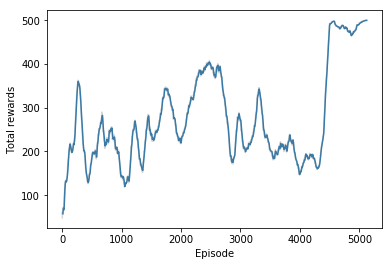

In [52]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

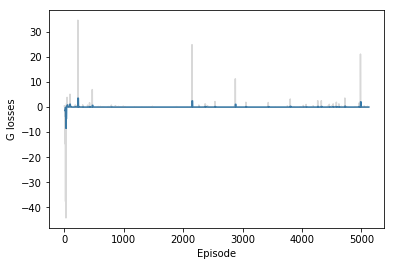

In [53]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

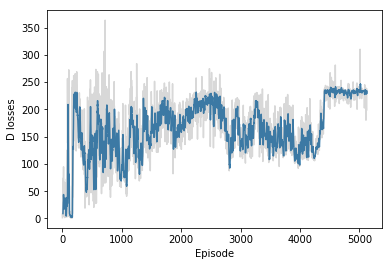

In [54]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses R')

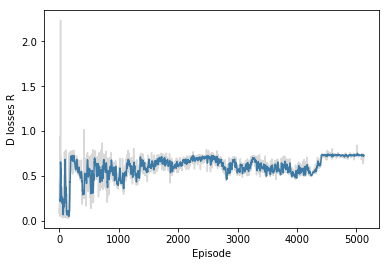

In [58]:
eps, arr = np.array(d_lossQsigm_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

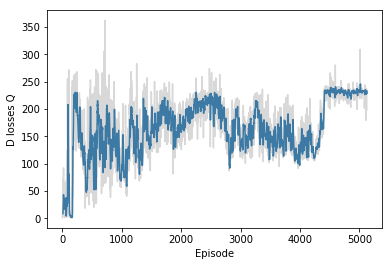

In [59]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [ ]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(11):
        state = env.reset()
        total_reward = 0
        g_initial_state = sess.run(model.g_initial_state)
        d_initial_state = sess.run(model.d_initial_state)

        # Training steps/batches
        while True:
            # Testing/inference
            env.render()
            action_logits, g_initial_state, d_initial_state = sess.run(
                fetches=[model.actions_logits, model.g_final_state, model.d_final_state], 
                feed_dict={model.states: np.reshape(state, [1, -1]),
                           model.g_initial_state: g_initial_state, 
                           model.d_initial_state: d_initial_state})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
# Closing the env
print('total_reward: {}'.format(total_reward))
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.